# Implementando nosso sistema de recomendação em Python usando Gradiente Descendente Estocástico (SGD)

SGD e ALS são dois algoritmos amplamente utilizados para fatorar a matriz de scores (usuário x item) em duas matrizes de dimensões menores, com o benefício de fazer as atualizações do modelo mais fáceis.

*Recapitulando algumas coisas*:
- **Filtragem Colaborativa** tem como principal vantagem o fato de ser capaz de recomendar itens complexos sem nenhum conhecimento anterior do item.
- **Baseados em Memória** usam a **similaridade** entre itens ou usuários, ex. usando a similaridade de cossenos.  
- **Baseados em Modelos** usam fatoração de matrizes.

 *O objetivo principal do algoritmo de fatoração de matrizes é modelar os ratings preditos através da minimização do erro quadrático relativo à matriz de fatores latentes de usuário $P$ e a matriz de fatores latentes de itens $Q$, sobre o conjunto de ratings reais:

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$(1)" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

Onde $K$ é um conjunto de pares $(u,i)$ tal que o rating é conhecido no conjunto de treino: por exemplo, $r_{ui}$ é o rating do item $i$ dado pelo usuário $u$ no conjunto de treino, e $\lambda$ é o parâmetro de regularização para evitar overfiting. O erro quadrático regularizado é a **função de perda** que você almeja minimizar. Depois de estimados $P$ e $Q$ através da minimização do erro quadrático, é possível prever os ratings desconhecidos pelo produto escalar dos fatores latentes dos usuários e dos itens.

O **gradiente descendente estocástico (SGD)** ou **método dos mínimos quadrados alternados (ALS)** pode ser aplicado para minimizar a função de perda. Ambos *SGD* e *ALS* podem ser usados para aprendizagem em tempo real, ou seja, atualizar o modelo de maneira incremental a cada vez que um novo rating é registrado.

## Pré-processamento

Aqui será utilizado o dataset MovieLens, onde você deve adicionar os arquivos descompactados do dataset em sua pasta de trabalho do Jupyter Notebook. O dataset pode ser baixado [aqui](http://files.grouplens.org/datasets/movielens/ml-100k.zip).
Primeiro, leia o arquivo **u.data** que contém o dataset completo. Uma descrição rápida do dataset pode ser encontrada [aqui](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

In [1]:
import numpy as np
import pandas as pd
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))  

Number of users = 943 | Number of movies = 1682


Você pode usar a biblioteca do [`scikit-learn`](http://scikit-learn.org/stable/) para dividir o dataset em duas porções de treino e teste. 
Ela mistura e divide os dados em dois datasets de acordo com a percentagem de exemplos de teste (``test_size``), que nesse caso é 0.25. O próximo passo será criar a matriz de ratings. Como teremos dados de treino e teste será necessário a criação de duas matrizes.

In [2]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df,test_size=0.25)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

As matrizes $I$ e $I2$ servirão como um seletor de matrizes, elas separarão os ratings apropriados de acordo com a atualização das equações durante o treino sobre o dataset de treino (usando $I$) e de predição sobre o dataset de teste (usando $I2$).

In [3]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

## Gradiente Descendente Estocástico com Regularização por Lambda Ponderado (SGD-WR)

Ao utilizar Filtragem Colaborativa com Gradiente Descendente Estocástico, é necessário estimar duas matrizes - a matriz de fatores latentes do usuário $P$ e a matriz de fatores latentes dos itens $Q$. Após estimadas $P$ e $Q$, podem ser preditos os ratings desconhecidos através do produto escalar das matrizes de fatores latentes de usuário e item. <img src="https://latex.codecogs.com/gif.latex?\hat&space;r_{ui}=P_u^TQ_i$&space;&space;$(2)" title="\hat r_{ui}=p_u^Tq_i" />

In [4]:
# Predict the unknown ratings through the dot product of the latent features for users and items 
def prediction(P,Q):
    return np.dot(P.T,Q)

#### Definição matemática do gradiente descendente estocástico quando utilizado para minimizar o erro quadrático regularizado (função de perda):

Para atualizar $P$ e $Q$, pode-se utilizar o gradiente descendente estocástico onde tu itera sobre cada observação (linha) no conjunto de treino e atualiza $Q$ e $P$ da seguinte maneira:
<img src="https://latex.codecogs.com/gif.latex?Q_{i&plus;1}&space;=&space;Q_i&space;&plus;&space;\gamma&space;(e_{ui}\cdot&space;P_u-\lambda\cdot&space;Q_i)$&space;&space;$(3)" title="Q_{i+1} = Q_i + \gamma (e_{ui}\cdot P_u-\lambda\cdot Q_i)" />

<img src="https://latex.codecogs.com/gif.latex?P_{u&plus;1}&space;=&space;P_u&space;&plus;&space;\gamma&space;(e_{ui}\cdot&space;Q_i-\lambda\cdot&space;P_u)$&space;&space;$(4)" title="P_{u+1} = P_u + \gamma (e_{ui}\cdot Q_i-\lambda\cdot P_u)" />

onde $\gamma$ é a taxa de aprendizagem e $\lambda$ é o parâmetro de regularização. O erro $(e)$ para o elemento $(u,i)$ é a diferença entre o rating predito e o rating real.
<img src="https://latex.codecogs.com/gif.latex?e_{ui}=r_{ui}-P_u^TQ_i$&space;&space;$(5)" title="e_{ui}=r_{ui}-p_u^Tq_i" />

Iniciamos definindo os parâmetros do algoritmo $\lambda$ (peso de regularização) e $k$ (dimensionalidade do espaço de fatores latentes), também iniciando as matrizes de fatores latentes $P$ e $Q$.

In [5]:
lmbda = 0.1 # Regularisation weight
k = 20  # Dimensionality of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

Existem várias métricas de avaliação, mas uma das mais populares utilizadas para avaliar a acurácia de ratings preditos é o Erro Quadrático Médio (RMSE), que vamos utilizar nesse tutorial:
<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(r_i&space;-\hat{r_i})^2} $&space;&space;$(6)" title="RMSE =\sqrt{\frac{1}{N} \sum (r_i -\hat{r_i})^2}" />

onde $N$ é o número de observações (linhas), $r_i$ é o rating real para a observação (linha) $i$ e $\hat{r_i}$ é o rating predito.
Como desejamos considerar apenas os ratings preditos que estão presentes nos conjuntos de treino e teste, filtramos todos os outros ratings na matriz de predição usando ``I`` e ``R[R > 0]``.

In [6]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

Agora implementaremos o SGD-WR onde utilizaremos as equações ``(3)``, ``(4)``, ``(5)`` definidas anteriormente.

In [7]:
train_errors = []
test_errors = []

#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i]) # Update latent movie feature matrix
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print ("[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse))

print("Algorithm converged")

[Epoch 1/100] train error: 3.754679, test error: 3.699914
[Epoch 2/100] train error: 2.464711, test error: 2.660250
[Epoch 3/100] train error: 2.091613, test error: 2.306635
[Epoch 4/100] train error: 1.847776, test error: 2.066396
[Epoch 5/100] train error: 1.659532, test error: 1.880100
[Epoch 6/100] train error: 1.509259, test error: 1.732914
[Epoch 7/100] train error: 1.389888, test error: 1.617646
[Epoch 8/100] train error: 1.296124, test error: 1.528132
[Epoch 9/100] train error: 1.222614, test error: 1.458361
[Epoch 10/100] train error: 1.164406, test error: 1.403124
[Epoch 11/100] train error: 1.117477, test error: 1.358408
[Epoch 12/100] train error: 1.078862, test error: 1.321363
[Epoch 13/100] train error: 1.046484, test error: 1.290047
[Epoch 14/100] train error: 1.018903, test error: 1.263144
[Epoch 15/100] train error: 0.995101, test error: 1.239737
[Epoch 16/100] train error: 0.974337, test error: 1.219167
[Epoch 17/100] train error: 0.956057, test error: 1.200944
[Epoch

Como foram guardados todos os  ``train_errors`` e ``test_errors`` para cada época, podemos plotar as curva de aprendizagem do algoritmo SGD-WR.

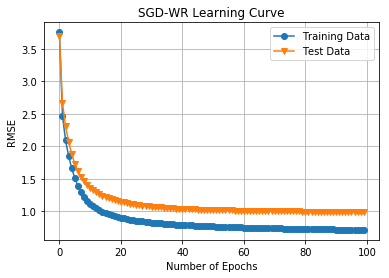

In [8]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('SGD-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

O modelo parece se comportar muito bem, com um RMSE relativamente baixo apor convergir. A performance pode ser influenciada através da calibragem dos parâmetros $\lambda$, $\gamma$ and $k$.


A seguir tu podes comparar o rating real com o rating predito. Para isso, primeiro calcula-se a matriz de rating preditos - para a qual utilizaremos a função ``prediction`` que foi definida anteriormente, e converter a matriz em um dataframe para facilitar o uso. <img src="https://latex.codecogs.com/gif.latex?\hat&space;r_{ui}=P_u^TQ_i$&space;&space;$(2)" title="\hat r_{ui}=p_u^Tq_i" /> 

In [9]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

Para se ter uma ideia do que foi atingido, vamos comparar algumas de nossas predições para o usuário ``29`` com seus ratings reais.

In [17]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[12,R.loc[12,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[12,R.loc[12,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
0,3.0,3.702658
1,3.0,2.952341
3,5.0,3.798026
4,1.0,2.183752
6,2.0,3.209168


## Referências
- [Koren et al. (2009)](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=8413B85890576DE006023342D58E8E67?doi=10.1.1.147.8295&rep=rep1&type=pdf) Koren, Y., Bell, R.M., Volinsky, C.: Matrix factorization techniques for recommender systems. IEEE Computer 42(8), 30–37 (2009) 32 Francesco Ricci, Lior Rokach and Bracha Shapira

<hr>
<strong>Este tutorial foi adaptado a partir do tutorial de Agnes Johannsdottir e Moritz Haller.</strong>

Agnes is a master student in Business Analytics at University College London. She studied Management Engineering in Iceland and worked for 2 years as an IT consultant in supply chain. Her main interests lie in using data science methods (especially machine learning) to apply in Retail and Supply Chain businesses.

Moritz has spent the past years in industry, working on business intelligence applications with the company he co-founded. He holds a BSc in Computer Science and is currently pursuing an MSc in Computer Science at University College London. His main interests lie in probabilistic modelling and machine learning.